In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import scipy.stats as stats
from scipy.stats import logistic

!pip install category_encoders 
from category_encoders.target_encoder import TargetEncoder

import pymc as pm
import arviz as az

az.style.use('arviz-darkgrid')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Prepare the data

In [60]:
data = pd.read_csv("Airlines.csv")
data.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


I'm using a flight dataset. It is necessary to predict whether the flight will be delayed or not.
data columns mean:  
**Airline** - transport company  
**Flight** - aircraft type  
**AirportFrom** - departure airport  
**AirportTo** - arrival airport  
**DayOfWeek** - day of the week of flight  
**Time** - departure time in minutes from midnight  
**Lenth** - flight duration in minutes  
**Delay** - Flight delay (target variable)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539383 entries, 0 to 539382
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           539383 non-null  int64 
 1   Airline      539383 non-null  object
 2   Flight       539383 non-null  int64 
 3   AirportFrom  539383 non-null  object
 4   AirportTo    539383 non-null  object
 5   DayOfWeek    539383 non-null  int64 
 6   Time         539383 non-null  int64 
 7   Length       539383 non-null  int64 
 8   Delay        539383 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 37.0+ MB


In [5]:
data.isna().sum()

id             0
Airline        0
Flight         0
AirportFrom    0
AirportTo      0
DayOfWeek      0
Time           0
Length         0
Delay          0
dtype: int64

Thus, there are no gaps in the data

In [61]:
data['Flight'] = data['Flight'].apply(str)
data['DayOfWeek'] = data['DayOfWeek'].apply(str)

There are many categorical features in the dataset, so One Hot Encoding is not suitable, as the table dimension increases to 6500 columns. Therefore, **TargetEncoding** method is better suited for these purposes.

In [62]:
enc_columns = ['Airline',	'Flight',	'AirportFrom', 	'AirportTo', 'DayOfWeek']
df = data.copy()
df.drop(['id'], inplace=True, axis=1)
enc = TargetEncoder(cols=enc_columns, smoothing=10)
enc.fit(df, df['Delay'])
numeric_dataset = enc.transform(df)

In [63]:
numeric_dataset.head()

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,0.566199,0.482955,0.532920,0.402933,0.470818,15,205,1
1,0.335971,0.625698,0.439931,0.319799,0.470818,15,222,1
2,0.388470,0.482713,0.496488,0.318151,0.470818,20,165,1
3,0.388470,0.602739,0.532920,0.318151,0.470818,20,195,1
4,0.339290,0.551887,0.317521,0.486322,0.470818,30,202,0


In [64]:
copy_data = numeric_dataset.copy()

In [11]:
target = numeric_dataset['Delay']
numeric_dataset.drop(['Delay'], inplace=True, axis=1)
df_train, df_test, y_train, y_test = train_test_split(numeric_dataset, target, test_size=0.985, random_state=42)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [12]:
df_train.shape

(8090, 7)

# Graphs of numerical features

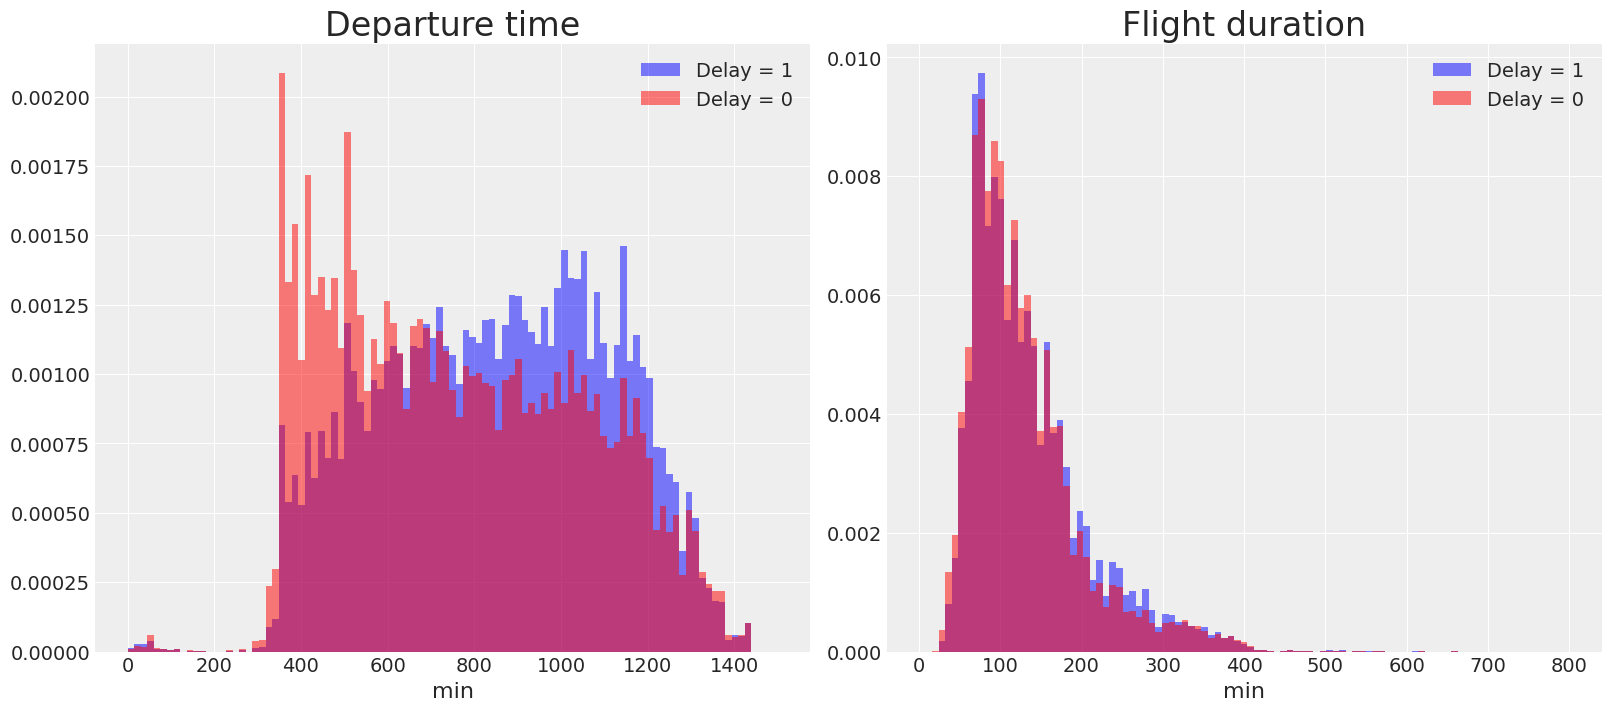

In [77]:
plt.figure(figsize=(16, 7))
# time
plt.subplot(1, 2, 1)
plt.title('Departure time', fontsize=24)
plt.xlabel('min', fontsize=16)
_, bins, _ = plt.hist(copy_data[copy_data.Delay==1].Time, bins=np.linspace(0,1500, 100),
                      density=True, alpha=0.5, color='blue', label='Delay = 1')
plt.hist(copy_data[copy_data.Delay==0].Time, bins=bins, 
         density=True, alpha=0.5, color='red', label='Delay = 0')
plt.legend(loc='best')

# flight duration
plt.subplot(1, 2, 2)
plt.title('Flight duration', fontsize=24)
plt.xlabel('min', fontsize=16)
_, bins, _ = plt.hist(copy_data[copy_data.Delay==1].Length, bins=np.linspace(0,800, 100),
                      density=True, alpha=0.5, color='blue', label='Delay = 1')
plt.hist(copy_data[copy_data.Delay==0].Length, bins=bins, 
         density=True, alpha=0.5, color='red', label='Delay = 0')
plt.legend(loc='best')

plt.show()

# MCMC approach


$$
t_i | x_i, \mathbf w \sim \mathrm{Be}(\theta(\mathbf x_i))
\\
\theta(x) = \mathrm{logit}(\mathbf w^T \mathbf x)
\\
\mathbf w_j \sim  \mathcal N(0, S_j)
$$

In [15]:
X = np.stack([df_train[col] for col in df_train.columns], axis=-1)

print('X.shape=', X.shape)
print('y_train.shape=', y_train.shape)

X.shape= (8090, 7)
y_train.shape= (8090,)


In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8090 entries, 420630 to 121958
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Airline      8090 non-null   float64
 1   Flight       8090 non-null   float64
 2   AirportFrom  8090 non-null   float64
 3   AirportTo    8090 non-null   float64
 4   DayOfWeek    8090 non-null   float64
 5   Time         8090 non-null   int64  
 6   Length       8090 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 505.6 KB


In [17]:
# collect data
x_means = X[:, [5, 6]].mean(axis=0)
print('x_means=', x_means)
x_scales = X[:, [5, 6]].std(axis=0)
print('x_scales=', x_scales)

zX = (X[:, [5, 6]]-x_means)/x_scales
zX = np.concatenate([zX, X[:, [0, 1, 2, 3, 4]]], axis=1)
zX = np.hstack([np.ones(shape=(zX.shape[0], 1)), zX])
zX = np.float16(zX)

zX.shape

x_means= [799.96093943 132.9894932 ]
x_scales= [277.95885629  70.19838048]


(8090, 8)

In [18]:
zX[:10]

array([[ 1.    , -0.8994,  0.4133,  0.4504,  0.4753,  0.488 ,  0.3838,
         0.4006],
       [ 1.    , -0.0898, -0.47  ,  0.6978,  0.693 ,  0.3845,  0.4968,
         0.4165],
       [ 1.    , -1.245 ,  0.328 ,  0.3013,  0.4607,  0.4087,  0.4355,
         0.4675],
       [ 1.    ,  0.648 ,  0.4844,  0.336 ,  0.5967,  0.4116,  0.4028,
         0.4006],
       [ 1.    ,  0.8813, -0.356 ,  0.379 ,  0.4607,  0.4844,  0.524 ,
         0.4473],
       [ 1.    , -0.1186,  1.012 ,  0.324 ,  0.565 ,  0.44  ,  0.3738,
         0.4707],
       [ 1.    ,  0.9536,  1.382 ,  0.3884,  0.474 ,  0.3977,  0.529 ,
         0.4675],
       [ 1.    , -1.475 ,  0.7407,  0.3481,  0.2563,  0.417 ,  0.4363,
         0.4006],
       [ 1.    ,  1.853 , -0.7974,  0.2429,  0.3943,  0.3857,  0.3198,
         0.4165],
       [ 1.    ,  1.26  ,  0.5557,  0.4504,  0.369 ,  0.3535,  0.392 ,
         0.4675]], dtype=float16)

# Sampling


Let's describe our model with which we will perform sampling

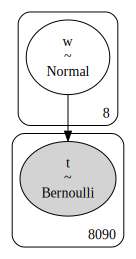

In [21]:
with pm.Model() as model:
    w = pm.Normal('w', mu=0, sigma=np.hstack([10, 2 * np.ones(shape=(zX.shape[1] - 1))]), 
                  shape=(8))  

    theta = pm.invlogit(pm.math.dot(w, zX.T))
    outputs = pm.Bernoulli('t', theta, observed=y_train)
    
pm.model_to_graphviz(model)

In [22]:
with model:
    trace = pm.sample(draws=3500, tune=1000, chains=4, cores=4,
                      return_inferencedata=True)

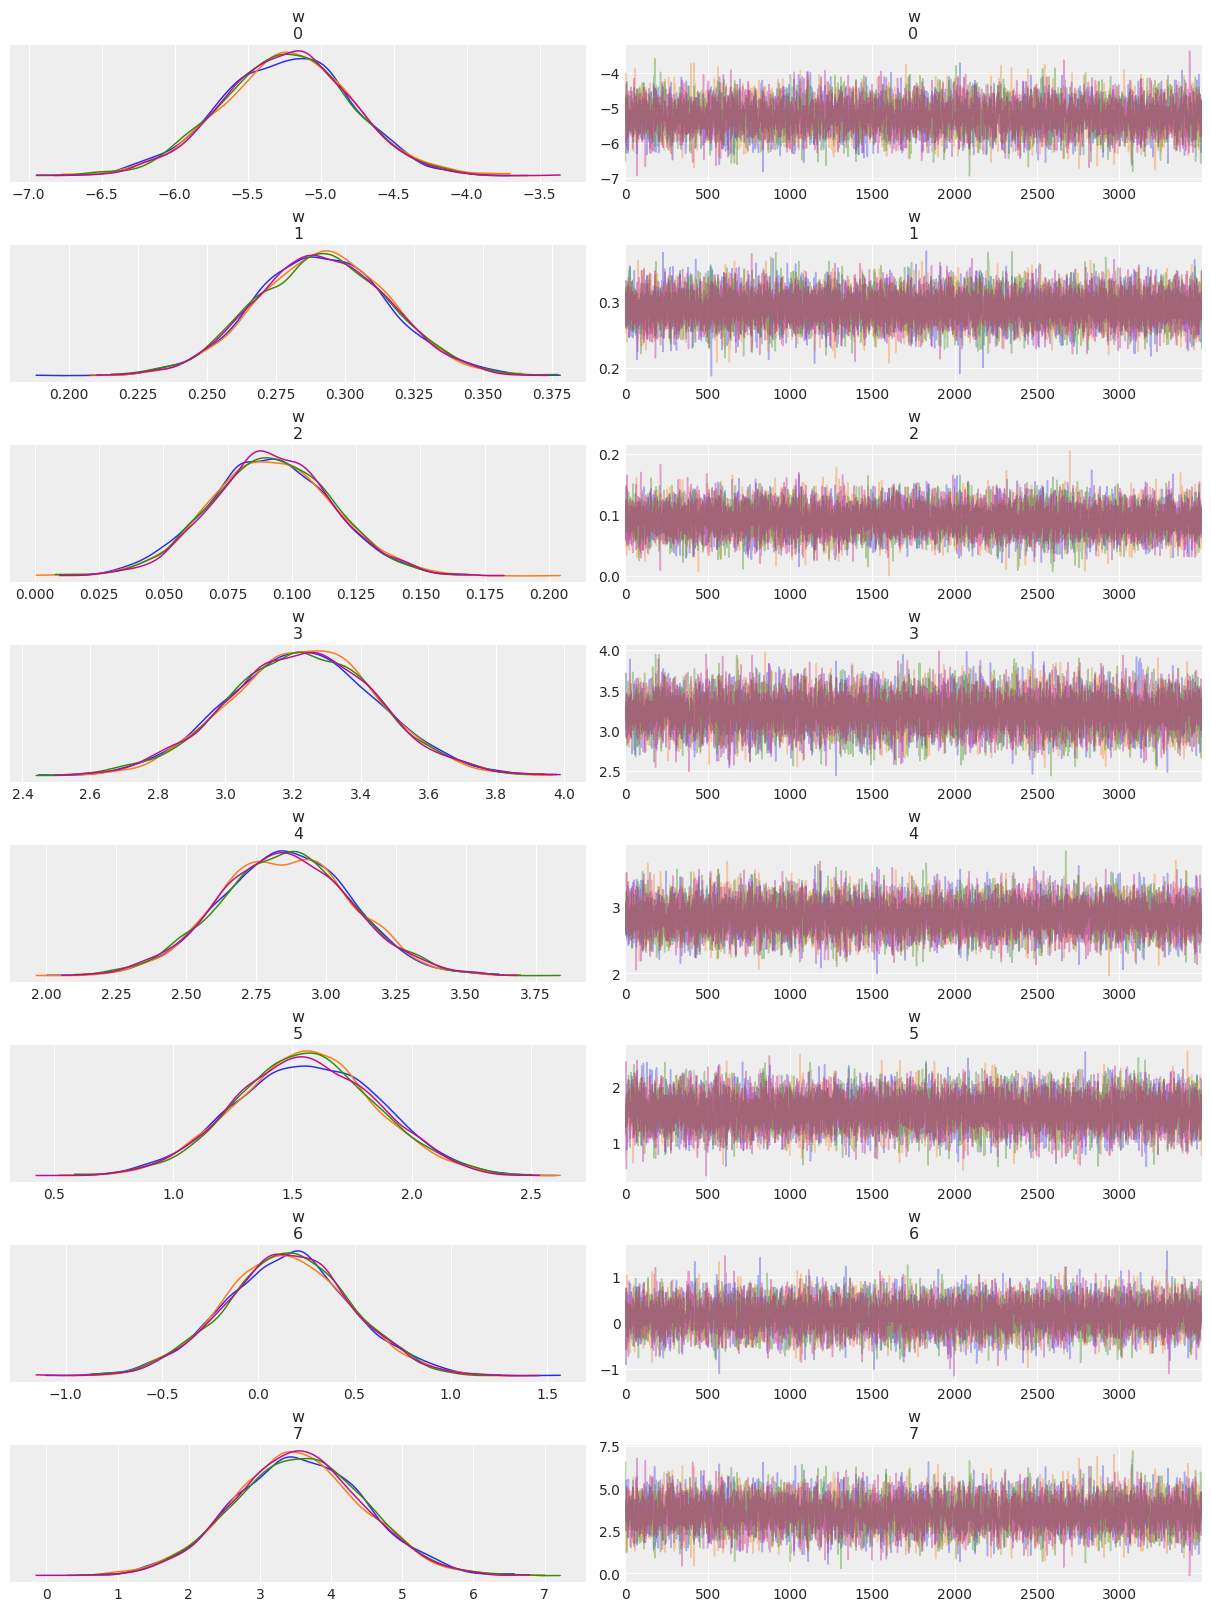

In [23]:
az.plot_trace(trace, compact=False);

According to the graphs, we see that the Markov chains converged, which means that the model was built correctly and the weights were selected.

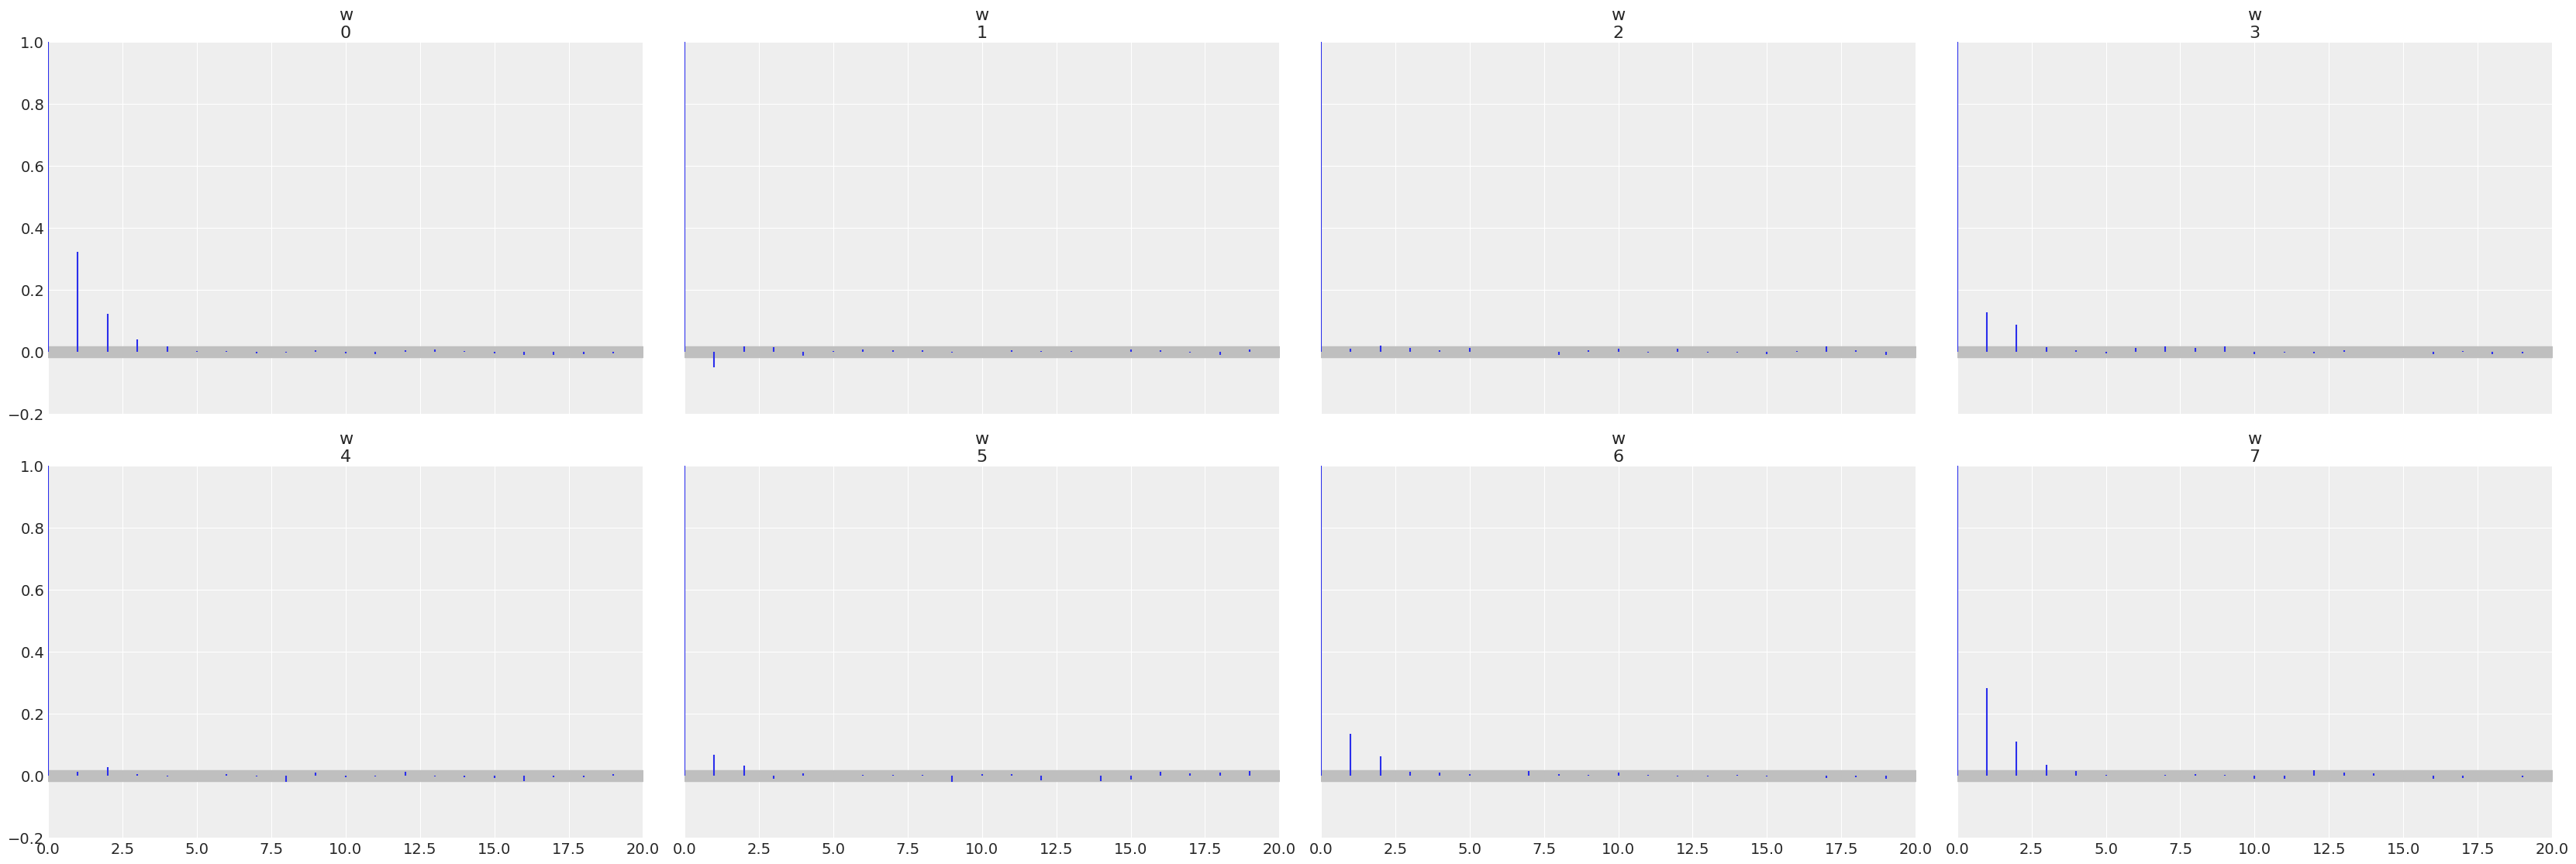

In [24]:
az.plot_autocorr(trace, max_lag=20, combined=True)
plt.ylim([-0.2, 1]);

Autocorrelations look good enough.

In [25]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],-5.238,0.447,-6.076,-4.393,0.005,0.004,7013.0,8566.0,1.0
w[1],0.292,0.024,0.248,0.338,0.000,0.000,14647.0,10695.0,1.0
w[2],0.092,0.024,0.045,0.135,0.000,0.000,12559.0,9397.0,1.0
w[3],3.228,0.220,2.809,3.638,0.002,0.002,9586.0,10185.0,1.0
w[4],2.854,0.236,2.431,3.318,0.002,0.001,12888.0,10491.0,1.0
w[5],1.557,0.294,1.031,2.135,0.003,0.002,11605.0,9993.0,1.0
w[6],0.152,0.326,-0.453,0.781,0.003,0.003,9294.0,9528.0,1.0
w[7],3.543,0.916,1.763,5.211,0.011,0.008,7380.0,8923.0,1.0


Model performance is also good.

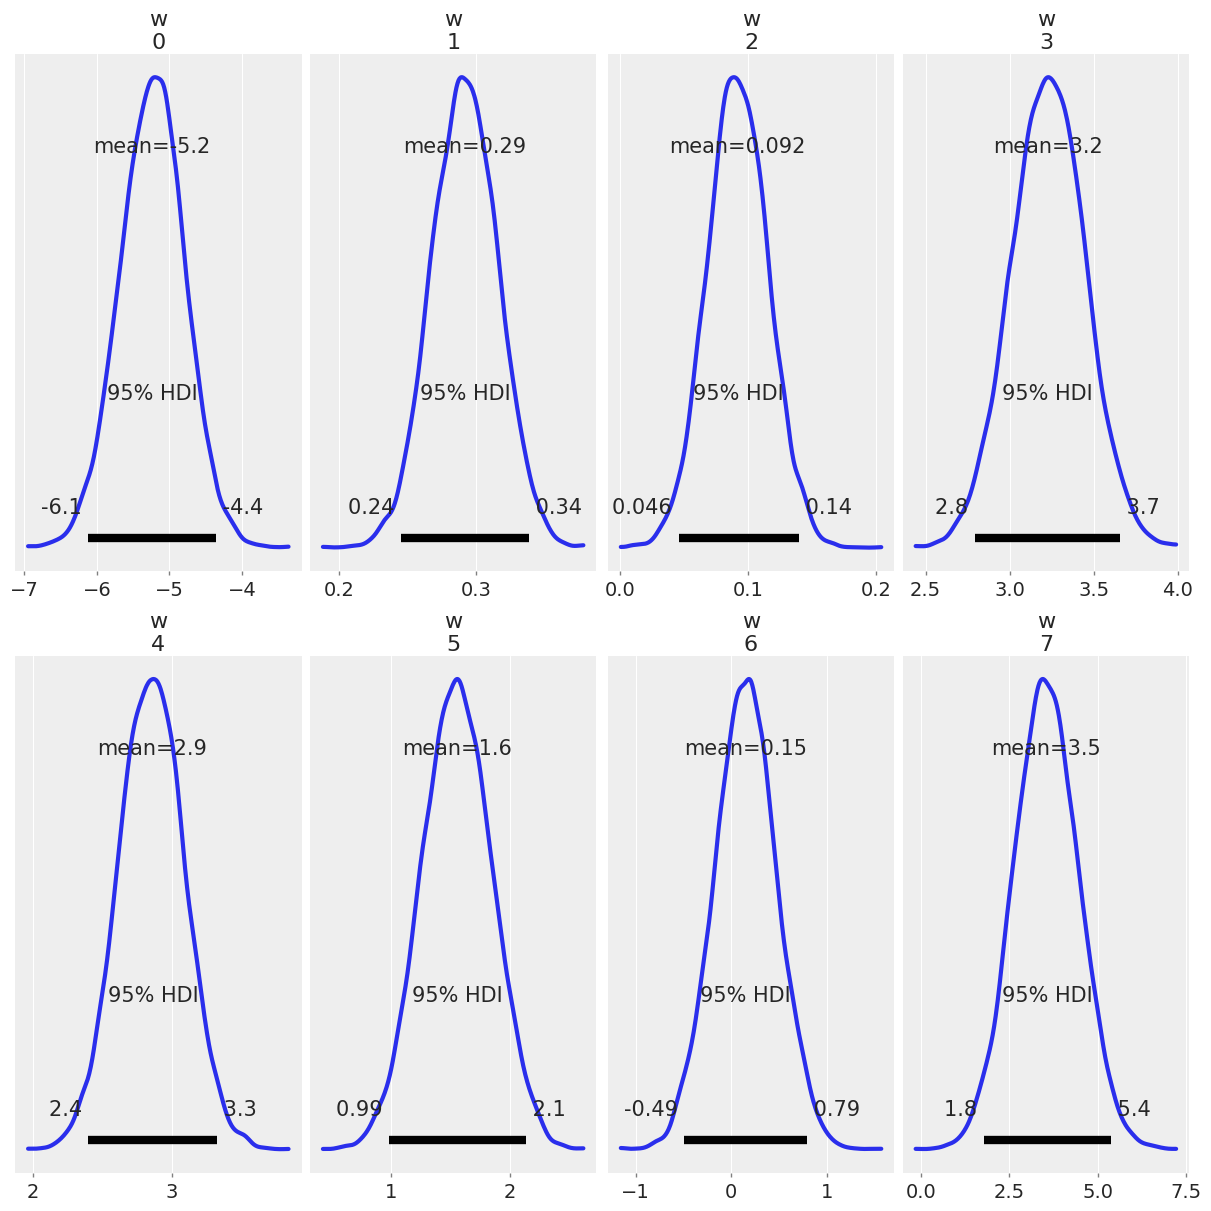

In [26]:
az.plot_posterior(trace, hdi_prob=0.95, figsize=(12, 12), lw=3);

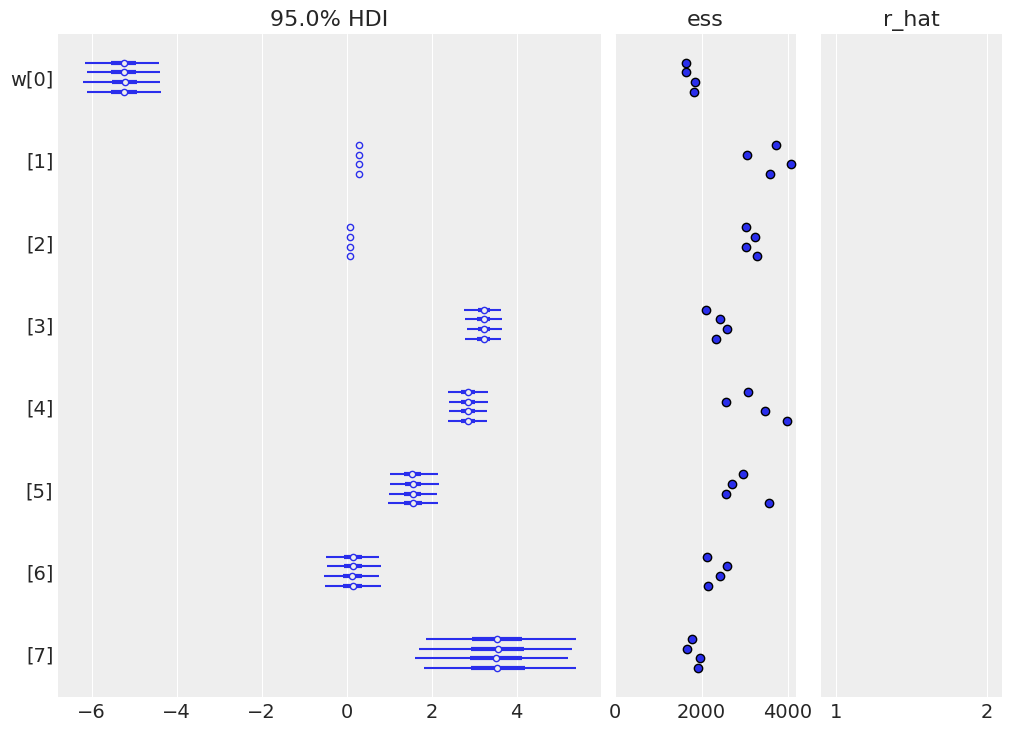

In [27]:
az.plot_forest(trace, hdi_prob=0.95, r_hat=True, ess=True);

## Prediction of new data

Transform weights back to original scale

In [28]:
w0_trace = trace.posterior['w'][...,0].values.reshape(-1)
w1_trace = trace.posterior['w'][...,1].values.reshape(-1)
w2_trace = trace.posterior['w'][...,2].values.reshape(-1)
w3_trace = trace.posterior['w'][...,3].values.reshape(-1)
w4_trace = trace.posterior['w'][...,4].values.reshape(-1)
w5_trace = trace.posterior['w'][...,5].values.reshape(-1)
w6_trace = trace.posterior['w'][...,6].values.reshape(-1)
w7_trace = trace.posterior['w'][...,7].values.reshape(-1)

w0_trace -= x_means[0] / x_scales[0] * w6_trace + x_means[1] / x_scales[1] * w7_trace
w6_trace /= x_scales[0]
w7_trace /= x_scales[1]

w_trace = np.stack([w0_trace, w1_trace, w2_trace, w3_trace, w4_trace, w5_trace, w6_trace, w7_trace], axis=-1)
w_trace.shape

(14000, 8)

In [53]:
X_test = df_test.sample(5000)

y = target.loc[X_test.index]

X_test = np.hstack([np.ones(shape=(X_test.shape[0], 1)), X_test])
X_test = np.float16(X_test)

In [54]:
delay_prob = logistic.cdf(w_trace.dot(X_test.T))
delay_prob = delay_prob.mean(axis=0).T

In [55]:
print('delay_prob.shape=', delay_prob.shape)
print('delay_prob.mean=', delay_prob.mean())
print('delay_prob.std=', delay_prob.std())

delay_prob.shape= (5000,)
delay_prob.mean= 0.27062674689429983
delay_prob.std= 0.3358904756532075


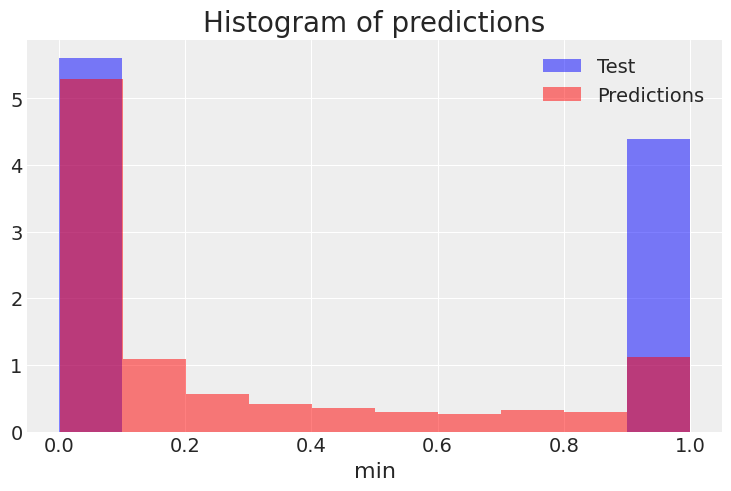

In [58]:
plt.title('Histogram of predictions', fontsize=20)
plt.xlabel('Delay', fontsize=16)
plt.hist(y, density=True, alpha=0.5, color='blue', label='Test')
plt.hist(delay_prob, density=True, alpha=0.5, color='red', label='Predictions')
plt.legend(loc='best')

So, we performed sampling, determined the feature weights, and made a prediction using the logistic function. As we can see, our predictions have a rather large error, so it may be worth adjusting the model or taking a larger training sample, since initially the dataset contains more than 6 thousand unique categories.